<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Bar_Magnet_Field_Lines_MagPyLib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 3.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/magpylib/_src/obj_classes/class_BaseExcitations.py:396: MagpylibDeprecationWarning: Cuboid(id=140463624196560) received a very low magnetization. In Magpylib v5 magnetization is given in units of A/m, while polarization is given in units of T.
  self._magnetization_low_warning()


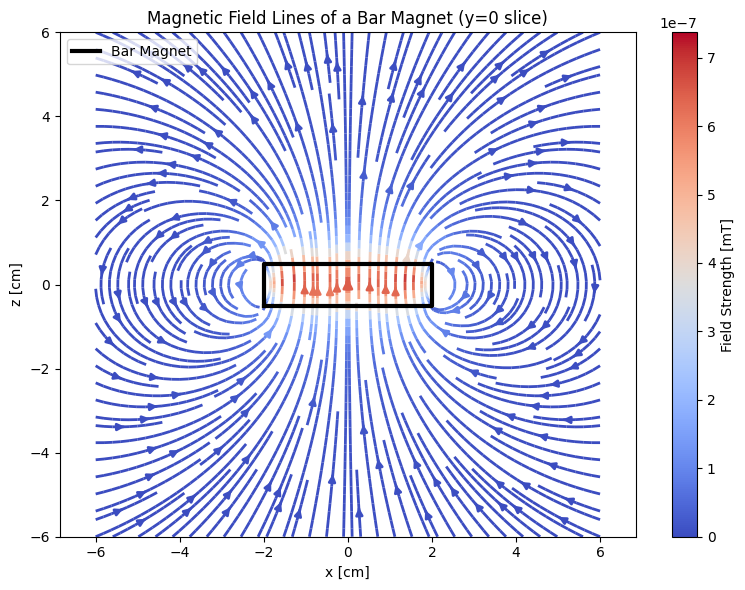

In [1]:
# Install Magpylib in Google Colab if needed
!pip install magpylib --quiet

import numpy as np
import matplotlib.pyplot as plt
from magpylib import Collection
from magpylib.magnet import Cuboid

# 1. Define the bar magnet: (length=4, width=1, height=1) in centimeters, magnetized along z-axis
magnet = Cuboid(
    magnetization=(0, 0, 1),  # [mT] Magnetized along the z-axis
    dimension=(4, 1, 1)       # [cm] Length (x), Width (y), Height (z)
)

# 2. Generate a grid of points (2D slice for clear plotting)
x = np.linspace(-6, 6, 25)
z = np.linspace(-6, 6, 25)
X, Z = np.meshgrid(x, z)
Y = np.zeros_like(X)  # y=0 plane

positions = np.stack([X, Y, Z], axis=-1).reshape(-1,3)

# 3. Compute the magnetic field at each point
B = magnet.getB(positions)  # mT
Bx = B[:,0].reshape(X.shape)
Bz = B[:,2].reshape(Z.shape)

# 4. Plot the vector field with streamlines
plt.figure(figsize=(8,6))
plt.title('Magnetic Field Lines of a Bar Magnet (y=0 slice)')
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.streamplot(
    X, Z, Bx, Bz,
    color=np.hypot(Bx, Bz),
    linewidth=2, cmap='coolwarm', density=2
)
# Draw the outline of the magnet for reference
magnet_outline = [
    [-2, -0.5], [2, -0.5], [2, 0.5], [-2, 0.5], [-2, -0.5]
]
magnet_outline = np.array(magnet_outline)
plt.plot(magnet_outline[:,0], magnet_outline[:,1], 'k-', lw=3, label='Bar Magnet')

plt.legend()
plt.colorbar(label='Field Strength [mT]')
plt.axis('equal')
plt.tight_layout()
plt.show()


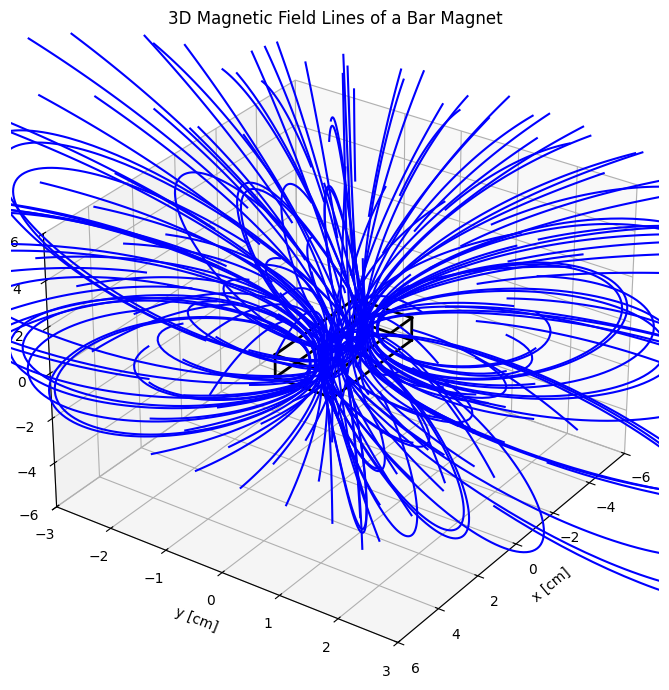

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from magpylib.magnet import Cuboid

from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# 1. Bar magnet definition
magnet = Cuboid(
    magnetization=(0, 0, 1e5),   # [A/m] in Magpylib v5+
    dimension=(4, 1, 1)          # [cm]
)

# 2. Define seed points for starting field lines (in a grid around the magnet)
n_per_axis = 6
x_seeds = np.linspace(-4, 4, n_per_axis)
y_seeds = np.linspace(-2, 2, n_per_axis)
z_seeds = np.linspace(-4, 4, n_per_axis)
seed_points = []
for x in x_seeds:
    for y in [y_seeds[0], y_seeds[-1]]:
        for z in z_seeds:
            seed_points.append([x, y, z])
    for y in y_seeds:
        for z in [z_seeds[0], z_seeds[-1]]:
            seed_points.append([x, y, z])
    for y in [y_seeds[0], y_seeds[-1]]:
        for z in [z_seeds[0], z_seeds[-1]]:
            seed_points.append([x, y, z])
seed_points = np.unique(seed_points, axis=0)  # Remove duplicates

# 3. Field line tracing function
def trace_field_line(start, magnet, step=0.1, n_steps=200):
    points = [np.array(start)]
    for _ in range(n_steps):
        pos = points[-1]
        B = magnet.getB(pos)
        norm = np.linalg.norm(B)
        if norm < 1e-5:
            break
        direction = B / norm
        next_pos = pos + direction * step
        points.append(next_pos)
        # Stop if we move too far away
        if np.linalg.norm(next_pos) > 10:
            break
    return np.array(points)

# 4. Plot field lines in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D Magnetic Field Lines of a Bar Magnet')

# Draw magnet as a black cuboid
lx, ly, lz = 4, 1, 1
magnet_center = [0, 0, 0]
rx = lx / 2
ry = ly / 2
rz = lz / 2
for s, e in [
    [[-rx,-ry,-rz],[rx,-ry,-rz]], [[rx,-ry,-rz],[rx,ry,-rz]], [[rx,ry,-rz],[-rx,ry,-rz]], [[-rx,ry,-rz],[-rx,-ry,-rz]],
    [[-rx,-ry,rz],[rx,-ry,rz]], [[rx,-ry,rz],[rx,ry,rz]], [[rx,ry,rz],[-rx,ry,rz]], [[-rx,ry,rz],[-rx,-ry,rz]],
    [[-rx,-ry,-rz],[-rx,-ry,rz]], [[rx,-ry,-rz],[rx,-ry,rz]], [[rx,ry,-rz],[rx,ry,rz]], [[-rx,ry,-rz],[-rx,ry,rz]]
]:
    ax.plot(*zip(s, e), color='k', linewidth=2)

# Trace and plot field lines
for seed in seed_points:
    path = trace_field_line(seed, magnet, step=0.15, n_steps=160)
    ax.plot(path[:,0], path[:,1], path[:,2], lw=1.5, color='blue')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
ax.set_xlim(-6, 6)
ax.set_ylim(-3, 3)
ax.set_zlim(-6, 6)
ax.view_init(30, 35)
plt.tight_layout()
plt.show()

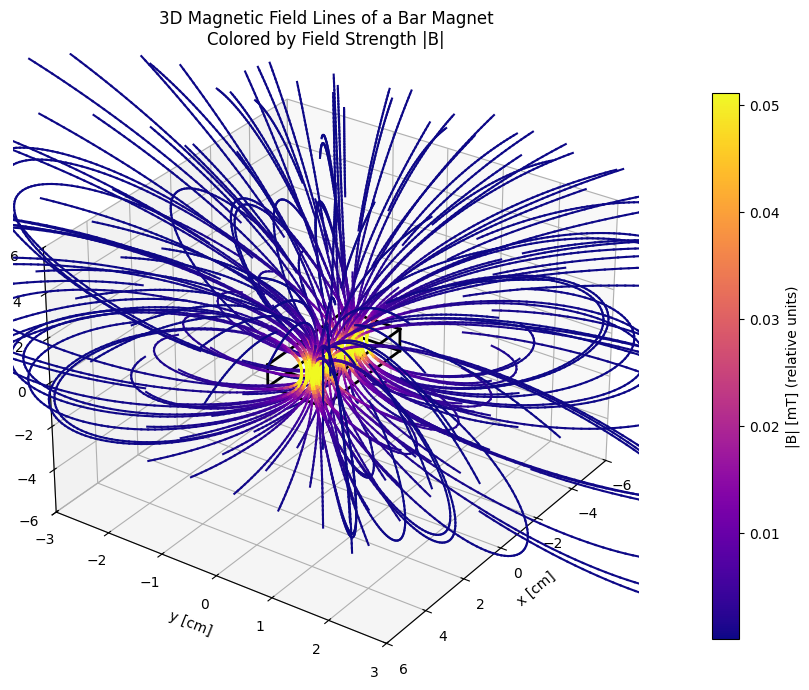

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from magpylib.magnet import Cuboid
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# 1. Bar magnet definition (realistic magnetization)
magnet = Cuboid(
    magnetization=(0, 0, 1e5),   # [A/m] in Magpylib v5+
    dimension=(4, 1, 1)          # [cm]
)

# 2. Define seed points (as before)
n_per_axis = 6
x_seeds = np.linspace(-4, 4, n_per_axis)
y_seeds = np.linspace(-2, 2, n_per_axis)
z_seeds = np.linspace(-4, 4, n_per_axis)
seed_points = []
for x in x_seeds:
    for y in [y_seeds[0], y_seeds[-1]]:
        for z in z_seeds:
            seed_points.append([x, y, z])
    for y in y_seeds:
        for z in [z_seeds[0], z_seeds[-1]]:
            seed_points.append([x, y, z])
    for y in [y_seeds[0], y_seeds[-1]]:
        for z in [z_seeds[0], z_seeds[-1]]:
            seed_points.append([x, y, z])
seed_points = np.unique(seed_points, axis=0)

# 3. Field line tracing function
def trace_field_line(start, magnet, step=0.1, n_steps=200):
    points = [np.array(start)]
    Bmags = []
    for _ in range(n_steps):
        pos = points[-1]
        B = magnet.getB(pos)
        norm = np.linalg.norm(B)
        if norm < 1e-5:
            break
        Bmags.append(norm)
        direction = B / norm
        next_pos = pos + direction * step
        points.append(next_pos)
        if np.linalg.norm(next_pos) > 10:
            break
    # One fewer magnitude than points (for segments), pad to match
    if Bmags:
        Bmags.append(Bmags[-1])
    return np.array(points), np.array(Bmags)

# 4. Plot field lines in 3D, colored by |B|
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D Magnetic Field Lines of a Bar Magnet\nColored by Field Strength |B|')

# Draw magnet as a black cuboid
lx, ly, lz = 4, 1, 1
rx, ry, rz = lx / 2, ly / 2, lz / 2
for s, e in [
    [[-rx,-ry,-rz],[rx,-ry,-rz]], [[rx,-ry,-rz],[rx,ry,-rz]], [[rx,ry,-rz],[-rx,ry,-rz]], [[-rx,ry,-rz],[-rx,-ry,-rz]],
    [[-rx,-ry,rz],[rx,-ry,rz]], [[rx,-ry,rz],[rx,ry,rz]], [[rx,ry,rz],[-rx,ry,rz]], [[-rx,ry,rz],[-rx,-ry,rz]],
    [[-rx,-ry,-rz],[-rx,-ry,rz]], [[rx,-ry,-rz],[rx,-ry,rz]], [[rx,ry,-rz],[rx,ry,rz]], [[-rx,ry,-rz],[-rx,ry,rz]]
]:
    ax.plot(*zip(s, e), color='k', linewidth=2)

# Prepare colormap and normalization
all_Bmags = []
# Pre-compute |B| values for normalization (optional speed-up for many seeds)
for seed in seed_points:
    _, Bmags = trace_field_line(seed, magnet, step=0.15, n_steps=160)
    all_Bmags.extend(Bmags)
all_Bmags = np.array(all_Bmags)
vmin = np.percentile(all_Bmags, 5)   # Ignore extreme low values
vmax = np.percentile(all_Bmags, 95)  # Ignore extreme high values
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = cm.plasma

# Trace and plot colored field lines
for seed in seed_points:
    path, Bmags = trace_field_line(seed, magnet, step=0.15, n_steps=160)
    if len(path) < 2:
        continue
    for i in range(len(path) - 1):
        color = cmap(norm(Bmags[i]))
        ax.plot(path[i:i+2,0], path[i:i+2,1], path[i:i+2,2], color=color, lw=1.5)

# Add a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.08)
cbar.set_label('|B| [mT] (relative units)')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
ax.set_xlim(-6, 6)
ax.set_ylim(-3, 3)
ax.set_zlim(-6, 6)
ax.view_init(30, 35)
plt.tight_layout()
plt.show()

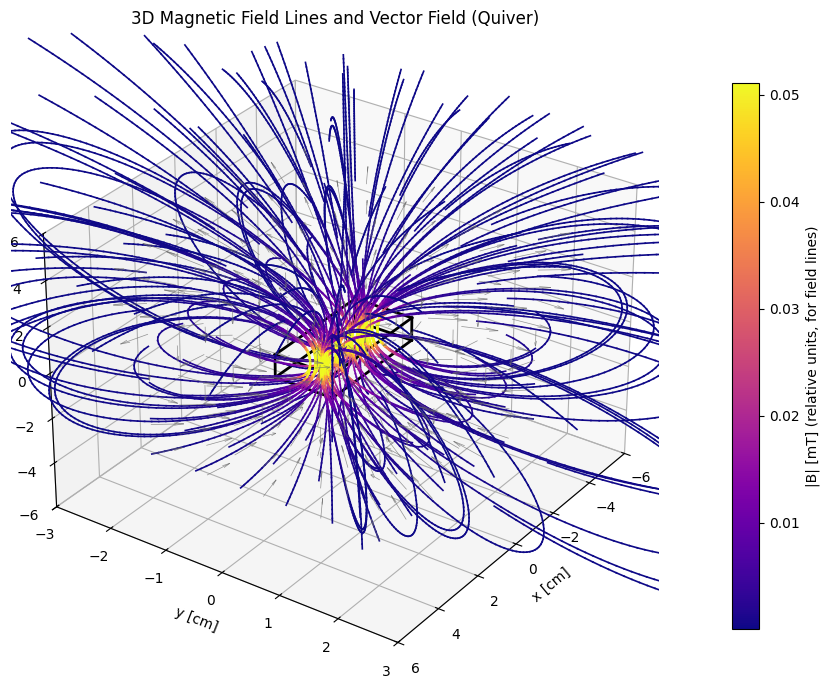

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from magpylib.magnet import Cuboid
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# 1. Bar magnet definition
magnet = Cuboid(
    magnetization=(0, 0, 1e5),   # [A/m] in Magpylib v5+
    dimension=(4, 1, 1)          # [cm]
)

# 2. Define seed points for field lines (as before)
n_per_axis = 6
x_seeds = np.linspace(-4, 4, n_per_axis)
y_seeds = np.linspace(-2, 2, n_per_axis)
z_seeds = np.linspace(-4, 4, n_per_axis)
seed_points = []
for x in x_seeds:
    for y in [y_seeds[0], y_seeds[-1]]:
        for z in z_seeds:
            seed_points.append([x, y, z])
    for y in y_seeds:
        for z in [z_seeds[0], z_seeds[-1]]:
            seed_points.append([x, y, z])
    for y in [y_seeds[0], y_seeds[-1]]:
        for z in [z_seeds[0], z_seeds[-1]]:
            seed_points.append([x, y, z])
seed_points = np.unique(seed_points, axis=0)

# 3. Field line tracing function (as before)
def trace_field_line(start, magnet, step=0.1, n_steps=200):
    points = [np.array(start)]
    Bmags = []
    for _ in range(n_steps):
        pos = points[-1]
        B = magnet.getB(pos)
        norm = np.linalg.norm(B)
        if norm < 1e-5:
            break
        Bmags.append(norm)
        direction = B / norm
        next_pos = pos + direction * step
        points.append(next_pos)
        if np.linalg.norm(next_pos) > 10:
            break
    if Bmags:
        Bmags.append(Bmags[-1])
    return np.array(points), np.array(Bmags)

# 4. Plot field lines in 3D, colored by |B|
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D Magnetic Field Lines and Vector Field (Quiver)')

# Draw magnet as a black cuboid
lx, ly, lz = 4, 1, 1
rx, ry, rz = lx / 2, ly / 2, lz / 2
for s, e in [
    [[-rx,-ry,-rz],[rx,-ry,-rz]], [[rx,-ry,-rz],[rx,ry,-rz]], [[rx,ry,-rz],[-rx,ry,-rz]], [[-rx,ry,-rz],[-rx,-ry,-rz]],
    [[-rx,-ry,rz],[rx,-ry,rz]], [[rx,-ry,rz],[rx,ry,rz]], [[rx,ry,rz],[-rx,ry,rz]], [[-rx,ry,rz],[-rx,-ry,rz]],
    [[-rx,-ry,-rz],[-rx,-ry,rz]], [[rx,-ry,-rz],[rx,-ry,rz]], [[rx,ry,-rz],[rx,ry,rz]], [[-rx,ry,-rz],[-rx,ry,rz]]
]:
    ax.plot(*zip(s, e), color='k', linewidth=2)

# Prepare colormap and normalization for field lines
all_Bmags = []
for seed in seed_points:
    _, Bmags = trace_field_line(seed, magnet, step=0.15, n_steps=160)
    all_Bmags.extend(Bmags)
all_Bmags = np.array(all_Bmags)
vmin = np.percentile(all_Bmags, 5)
vmax = np.percentile(all_Bmags, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = cm.plasma

# Trace and plot colored field lines
for seed in seed_points:
    path, Bmags = trace_field_line(seed, magnet, step=0.15, n_steps=160)
    if len(path) < 2:
        continue
    for i in range(len(path) - 1):
        color = cmap(norm(Bmags[i]))
        ax.plot(path[i:i+2,0], path[i:i+2,1], path[i:i+2,2], color=color, lw=1.2)

# 5. Add classic 3D quiver plot at a coarse grid
xq = np.linspace(-4, 4, 7)
yq = np.linspace(-2, 2, 5)
zq = np.linspace(-4, 4, 7)
Xq, Yq, Zq = np.meshgrid(xq, yq, zq)
Uq, Vq, Wq = np.zeros_like(Xq), np.zeros_like(Yq), np.zeros_like(Zq)

for idx, _ in np.ndenumerate(Xq):
    B = magnet.getB([Xq[idx], Yq[idx], Zq[idx]])
    Uq[idx], Vq[idx], Wq[idx] = B

# Normalize quiver vectors for visualization clarity
Bmag_q = np.sqrt(Uq**2 + Vq**2 + Wq**2)
Uqn = Uq / (Bmag_q + 1e-12)
Vqn = Vq / (Bmag_q + 1e-12)
Wqn = Wq / (Bmag_q + 1e-12)

ax.quiver(Xq, Yq, Zq, Uqn, Vqn, Wqn, length=0.7, color='dimgray', alpha=0.7, linewidth=0.5)

# Add a colorbar for field lines
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.08)
cbar.set_label('|B| [mT] (relative units, for field lines)')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
ax.set_xlim(-6, 6)
ax.set_ylim(-3, 3)
ax.set_zlim(-6, 6)
ax.view_init(30, 35)
plt.tight_layout()
plt.show()

In [12]:
# Install packages in Colab if needed
!pip install plotly --quiet

import numpy as np
import magpylib as magpy
from magpylib.magnet import Cuboid
import plotly.graph_objects as go
from matplotlib.colors import Normalize
from matplotlib import cm

# Bar magnet
magnet = Cuboid(
    magnetization=(0, 0, 1e5),
    dimension=(4, 1, 1)
)

# Seed points for field lines
n_per_axis = 6
x_seeds = np.linspace(-4, 4, n_per_axis)
y_seeds = np.linspace(-2, 2, n_per_axis)
z_seeds = np.linspace(-4, 4, n_per_axis)
seed_points = []
for x in x_seeds:
    for y in [y_seeds[0], y_seeds[-1]]:
        for z in z_seeds:
            seed_points.append([x, y, z])
    for y in y_seeds:
        for z in [z_seeds[0], z_seeds[-1]]:
            seed_points.append([x, y, z])
    for y in [y_seeds[0], y_seeds[-1]]:
        for z in [z_seeds[0], z_seeds[-1]]:
            seed_points.append([x, y, z])
seed_points = np.unique(seed_points, axis=0)

# Field line tracing
def trace_field_line(start, magnet, step=0.1, n_steps=200):
    points = [np.array(start)]
    Bmags = []
    for _ in range(n_steps):
        pos = points[-1]
        B = magnet.getB(pos)
        norm = np.linalg.norm(B)
        if norm < 1e-5:
            break
        Bmags.append(norm)
        direction = B / norm
        next_pos = pos + direction * step
        points.append(next_pos)
        if np.linalg.norm(next_pos) > 10:
            break
    if Bmags:
        Bmags.append(Bmags[-1])
    return np.array(points), np.array(Bmags)

# Compute all field lines and |B| for normalization
all_Bmags = []
paths = []
Bmags_paths = []
for seed in seed_points:
    path, Bmags = trace_field_line(seed, magnet, step=0.15, n_steps=160)
    if len(path) > 1:
        paths.append(path)
        Bmags_paths.append(Bmags)
        all_Bmags.extend(Bmags)
all_Bmags = np.array(all_Bmags)
vmin = np.percentile(all_Bmags, 5)
vmax = np.percentile(all_Bmags, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = cm.plasma

# Plotly field line segments (each segment is a trace)
line_traces = []
for path, Bmags in zip(paths, Bmags_paths):
    for i in range(len(path)-1):
        rgb = (np.array(cmap(norm(Bmags[i]))[:3])*255).astype(int)
        color = f'rgb({int(rgb[0])},{int(rgb[1])},{int(rgb[2])})'
        seg = path[i:i+2]
        line_traces.append(
            go.Scatter3d(
                x=seg[:,0], y=seg[:,1], z=seg[:,2],
                mode='lines',
                line=dict(color=color, width=4),
                showlegend=False,
                hoverinfo='none'
            )
        )

# Quiver (vector field) as lines
xq = np.linspace(-4, 4, 7)
yq = np.linspace(-2, 2, 5)
zq = np.linspace(-4, 4, 7)
Xq, Yq, Zq = np.meshgrid(xq, yq, zq)
arrow_traces = []
arrow_length = 1.0

for ix in range(Xq.size):
    pos = np.array([Xq.flatten()[ix], Yq.flatten()[ix], Zq.flatten()[ix]])
    B = magnet.getB(pos)
    normB = np.linalg.norm(B)
    if normB < 1e-5:
        continue
    B_dir = B / normB
    start = pos
    end = pos + arrow_length * B_dir
    arrow_traces.append(
        go.Scatter3d(
            x=[start[0], end[0]],
            y=[start[1], end[1]],
            z=[start[2], end[2]],
            mode='lines',
            line=dict(color='dimgray', width=5),
            showlegend=False,
            hoverinfo='none'
        )
    )

# Magnet cuboid as a wireframe
def get_cuboid_edges(center, size):
    x, y, z = center
    dx, dy, dz = size[0]/2, size[1]/2, size[2]/2
    points = np.array([
        [x-dx, y-dy, z-dz], [x+dx, y-dy, z-dz], [x+dx, y+dy, z-dz], [x-dx, y+dy, z-dz],
        [x-dx, y-dy, z+dz], [x+dx, y-dy, z+dz], [x+dx, y+dy, z+dz], [x-dx, y+dy, z+dz],
    ])
    edge_indices = [
        (0,1),(1,2),(2,3),(3,0),
        (4,5),(5,6),(6,7),(7,4),
        (0,4),(1,5),(2,6),(3,7)
    ]
    edges = []
    for i,j in edge_indices:
        edges.append((points[i], points[j]))
    return edges

cuboid_edges = get_cuboid_edges((0,0,0), (4,1,1))
cuboid_traces = [
    go.Scatter3d(
        x=[e[0][0], e[1][0]],
        y=[e[0][1], e[1][1]],
        z=[e[0][2], e[1][2]],
        mode='lines',
        line=dict(color='black', width=8),
        showlegend=False,
        hoverinfo='none'
    )
    for e in cuboid_edges
]

# Dummy scatter3d to show colorbar (colorbar does not correspond to data, but for reference)
colorbar_trace = go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode='markers',
    marker=dict(
        colorscale='Plasma',
        cmin=vmin,
        cmax=vmax,
        color=[vmin, vmax],  # For the colorbar range
        colorbar=dict(
            title='|B| [arb. units]',
            thickness=20,
            x=1.05,
            tickvals=[vmin, vmax],
            ticktext=[f"{vmin:.0f}", f"{vmax:.0f}"]
        )
    ),
    showlegend=False
)

# Combine all traces
fig = go.Figure(
    data=line_traces + arrow_traces + cuboid_traces + [colorbar_trace]
)

fig.update_layout(
    title="3D Magnetic Field Lines and Vector Field (Quiver) of a Bar Magnet",
    scene=dict(
        xaxis=dict(title='x [cm]', range=[-6,6]),
        yaxis=dict(title='y [cm]', range=[-3,3]),
        zaxis=dict(title='z [cm]', range=[-6,6]),
        aspectratio=dict(x=1, y=0.5, z=1),
    ),
    width=900,
    height=700,
    showlegend=False
)

fig.show()